[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/estadistica/blob/main/trabajo3/trabajo3.ipynb)

In [29]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# We will use some methods from the sklearn module
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import normalize

import scipy.stats as stats
from scipy.stats import bartlett, shapiro
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display, Markdown

# Trabajo 3

## Base de datos

En un estudio a gran escala realizado en EE.UU sobre la eficacia en el control de infecciones hospitalarias se recogió información en 113 hospitales. A su equipo de trabajo le corresponde analizar una muestra aleatoria de n hospitales, que están dentro de un archivo de texto adjunto, donde n es el número de registros en el archivo asignado y X es el número de equipo asignad. La base de datos contiene las siguientes columnas (variables):
* **Y**: Riesgo de infección Probabilidad promedio estimada de adquirir infección en el hospital (en porcentaje).
* **$X_1$**: Duración de la estadía Duración promedio de la estadía de todos los pacientes en el hospital (en días).
* **$X_2$**: Rutina de cultivos Razón del número de cultivos realizados en pacientes sin síntomas de infección hospitalaria,
por cada 100.
* **$X_3$**: Número de camas Número promedio de camas en el hospital durante el periodo del estudio.
* **$X_4$**: Censo promedio diario Número promedio de pacientes en el hospital por día durante el periodo del estudio.
* **X5**:Número de enfermerasNúmero promedio de enfermeras, equivalentes a tiempo completo, durante el periodo
del estudio.

Se pide lo siguiente:

1. Emplee el análisis de regresión lineal múltiple que explique el riesgo de infección en términos de las variables restantes (actuando como predictoras $X_i$).
2. Identifique observaciones que puedan considerarse problemáticas (datos atípicos, puntos de balanceo e influyentes) y analice si debe eliminarlas de su conjunto de datos o no, justifique. 
3. Repita la construcción del modelo de regresión si eliminó observaciones.
4. Realice la prueba de significancia del modelo, interprete.
5. Obtener el coeficiente de determinación y el coeficiente de determinación ajustado. Interprete.
6. Analice si hay problemas de multicolinealidad.
7. Realice una selección e variables por el método que prefiera, tome decisiones, explique.
8. Realice una predicción utilizando el modelo seleccionado, interprete.

### Carga y analisis simple de la base de datos

In [30]:
# Leer archivo csv

raw_data_url = "https://raw.githubusercontent.com/repos-especializacion-UdeA/estadistica/refs/heads/main/trabajo3/Datos.csv"

# Leer el archivo CSV
df = pd.read_csv(raw_data_url)

# Mostrar las primeras filas del DataFrame
df.head()

,Y,X1,X2,X3,X4,X5
0,4.8,9.84,62.2,12.0,82.3,600
1,5.0,11.03,49.9,19.7,102.1,318
2,4.4,11.65,54.5,18.6,96.1,248
3,3.7,8.48,51.1,12.1,92.8,166
4,5.5,11.08,50.2,18.6,63.6,387


### Funciones resumen

In [31]:
df.shape

(59, 6)

In [32]:
# Información resumida de los datos numericos
df.describe()

,Y,X1,X2,X3,X4,X5
count,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000
mean,4.335593,9.72678,53.452542,16.128814,81.449153,281.525424
std,1.237735,1.76993,4.023652,10.162525,19.129192,217.963723
min,1.300000,7.13000,42.000000,1.900000,39.600000,29.000000
25%,3.700000,8.51000,51.200000,8.700000,70.100000,114.000000
50%,4.400000,9.44000,53.800000,15.700000,82.500000,195.000000
75%,5.000000,10.75500,56.150000,20.700000,92.550000,335.500000
max,7.600000,17.94000,62.200000,60.500000,122.800000,835.000000


In [33]:
df.corr()

,Y,X1,X2,X3,X4,X5
Y,1.000000,0.514586,-0.138757,0.442119,0.433135,0.460360
X1,0.514586,1.000000,0.092463,0.305234,0.334557,0.517463
X2,-0.138757,0.092463,1.000000,-0.279236,-0.115365,-0.090632
X3,0.442119,0.305234,-0.279236,1.000000,0.459671,0.192034
X4,0.433135,0.334557,-0.115365,0.459671,1.000000,0.059914
X5,0.460360,0.517463,-0.090632,0.192034,0.059914,1.000000


### Estimación del modelo

El modelo se obtiene emplando el método de ajuste por mínimos cuadrados ordinarios (OLS).

In [34]:
# Para ajustar el modelo utilizando el modo fórmula, es necesario que los datos
# estén almacenados en un único dataframe.

model = smf.ols(
     formula = 'Y ~ X1 + X2 + X3 + X4 + X5',
     data = df
).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     8.593
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           5.17e-06
Time:                        21:33:36   Log-Likelihood:                -78.282
No. Observations:                  59   AIC:                             168.6
Df Residuals:                      53   BIC:                             181.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5143      1.898      0.798      0.429      -2.294       5.322
X1             0.1628      0.093      1.757      0.085      -0.023       0.349
X2            -0.0165      0.034     -0.487      0.628      -0.084       0.051
X3             0.0230      0.015      1.544      0.129      -0.007       0.053
X4             0.0159      0.008      2.042      0.046       0.000       0.031
X5             0.0016      0.001      2.312      0.025       0.000       0.003
==============================================================================
Omnibus:                        0.652   Durbin-Watson:                   2.417
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.754
Skew:                           0.222   Prob(JB):                        0.686
Kurtosis:                       2.669   Cond. No.                     5.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El modelo resultante esta definido por:

$$Y = 1.5143 + 0.1628X_1 - 0.0165X_2 + 0.0230X_3 + 0.0159X_4 + 0.0016X_5$$

Ajustar el modelo consiste en estimar, a partir de los datos disponibles, los valores de los coeficientes de regresión que maximizan la verosimilitud (likelihood), es decir, los que dan lugar al modelo que con mayor probabilidad puede haber generado los datos observados.

## Bondad de ajuste del modelo

Tenemos de la columna:
* Error estándar de los residuos (Residual Standar Error, RSE): 
 
  ```
  Adj. R-squared:	0.396 
  ```

* Coeficiente de determinación  $R^2$: 
  
  ```
  R-squared:	0.448
  ```

* Valor Estadistico F y valor P :
  
  ```
  F-statistic:	8.593
  Prob (F-statistic):	5.17e-06
  ```

* Significancia del modelo F-test:
 
Los valores p (o p-values) de los predictores en un modelo de regresión se comparan con un umbral de significancia estadística, comúnmente llamado nivel de significancia (denotado como $\alpha = 0.05$). Con:
* **Predictor estadisticamente significativo**: Si $VP < \alpha$ de modo que tiene una influencia relevante en la variable dependiente.
* **Predictor estadisticamente no significativo**: Si $VP > \alpha$: no hay suficiente evidencia para afirmar que el predictor tiene un efecto significativo en la variable dependiente.

La siguiente funcion obtiene segun lo anterior las variables significativas para el modelo:

In [35]:
# Crear un DataFrame con los valores p

p_values_df = pd.DataFrame(model.pvalues, columns=['p_value'])
p_values_df 

significativo = lambda p_value, alpha=0.05: True if p_value < alpha else False
p_values_df['significancia'] = p_values_df['p_value'].apply(significativo)
p_values_df

,p_value,significancia
Intercept,0.428630,False
X1,0.084665,False
X2,0.628346,False
X3,0.128542,False
X4,0.046120,True
X5,0.024718,True


In [36]:
# Función para obtener las variables significativas
def obtener_variables_significativas(model, alpha=0.05):
    # Ajustar el modelo de regresión
    
    # Obtener las p-valores de los predictores
    p_values = model.pvalues
    
    # Filtrar las variables con p-valor menor que alpha
    variables_significativas = p_values[p_values < alpha].index.tolist()
    
    return variables_significativas

In [37]:
variables_significativas = obtener_variables_significativas(model)
variables_significativas

['X4', 'X5']

## Identificacion de puntos atipicos

### Distancia de Cook

In [38]:
# Calcular la distancia de Cook
influencia = model.get_influence()

# Calcular la distancia de Cook
cooks_d = influencia.cooks_distance[0]
# Calcular los valores de apalancamiento (hii)
hii_values = influencia.hat_matrix_diag
# Calcular los residuales estudentizados
rstudent_values = influencia.resid_studentized_external
# Calcular los valores DFFITS
dffits_values = influencia.dffits[0]
# Calcular los valores DFbeta
dfbeta_values = influencia.dfbetas

# Crear un DataFrame con todos los valores de influencia
influence_df = pd.DataFrame({
    'Leverage (hii)': hii_values,
    'Cooks Distance': cooks_d,
    'R-Student': rstudent_values,
    'DFFITS': dffits_values
    # Puedes agregar más métricas si lo deseas
})

# Mostrar el DataFrame
display(influence_df)

,Leverage (hii),Cooks Distance,R-Student,DFFITS
0,0.180360,0.001202,0.179408,0.084159
1,0.057051,0.000065,-0.079473,-0.019548
2,0.051793,0.002259,-0.494597,-0.115594
3,0.050941,0.001412,-0.394105,-0.091306
4,0.077732,0.014745,1.025023,0.297581
5,0.064841,0.026946,-1.546928,-0.407336
6,0.109914,0.002620,-0.353848,-0.124345
7,0.126799,0.019050,0.885394,0.337393
8,0.027164,0.000139,-0.171543,-0.028665
9,0.040716,0.001995,0.527434,0.108662


Residuales estudentizados (mejor criterio en regresión):
Los residuales estudentizados o r-student son residuales que han sido estandarizados por su varianza, lo que permite una mejor comparación entre diferentes observaciones. Se utilizan frecuentemente para identificar outliers en modelos de regresión.

Criterio:
* Un residual estudentizado mayor a 2 o menor a -2 es considerado sospechoso.
* Un residual estudentizado mayor a 3 o menor a -3 se considera un outlier significativo.
* En modelos con grandes muestras, el umbral de ±2 suele ser suficiente para identificar posibles outliers.

In [39]:
mask_outliers = influence_df['R-Student'].apply(lambda x: True if abs(x) > 2 else False)
outliers = influence_df[mask_outliers]
outliers


,Leverage (hii),Cooks Distance,R-Student,DFFITS
39,0.130139,0.183639,2.896877,1.120493


La distancia de Cook mide cuánto cambian los coeficientes del modelo si se elimina una observación. Un valor alto de distancia de Cook indica que el punto es influyente.
Criterio:
Un valor de distancia de Cook mayor a 1 o  4/n (donde n es el número de observaciones) se considera influyente.

In [40]:
## Puntos de balanceo

leverage_threshold = 2 * (len(df.columns)) / len(df)
high_leverage_points = df[hii_values > leverage_threshold]
high_leverage_points


,Y,X1,X2,X3,X4,X5
24,2.9,10.79,44.2,2.6,56.6,461
28,5.9,17.94,56.2,26.4,91.8,835
36,4.9,11.07,53.2,28.5,122.0,768
47,5.4,11.18,45.7,60.5,85.8,640


In [41]:
mask_influence_points = influence_df['Cooks Distance'].apply(lambda x: True if x > 4/len(influence_df) else False)
influence_points = influence_df[mask_influence_points]
influence_points


,Leverage (hii),Cooks Distance,R-Student,DFFITS
24,0.249065,0.143863,-1.638671,-0.943729
28,0.408237,0.218789,-1.391585,-1.155824
36,0.206046,0.110620,-1.623723,-0.827174
39,0.130139,0.183639,2.896877,1.120493
47,0.435206,0.229908,-1.348265,-1.183525


## Eliminando los puntos de influencia

### Outliers

Las observaciones 24, 28, 36 y 47 tienen valores de apalancamiento elevados (mayores que el umbral calculado).

In [42]:
# Filtrar los puntos influyentes (24, 28, 36, 39 y 47)
non_influential_data = df.drop([24, 28, 36, 39, 47])
non_influential_data


,Y,X1,X2,X3,X4,X5
0,4.8,9.84,62.2,12.0,82.3,600
1,5.0,11.03,49.9,19.7,102.1,318
2,4.4,11.65,54.5,18.6,96.1,248
3,3.7,8.48,51.1,12.1,92.8,166
4,5.5,11.08,50.2,18.6,63.6,387
5,1.7,8.09,56.9,7.6,56.9,92
6,4.5,10.05,52.0,36.7,87.5,184
7,5.7,11.20,56.5,34.5,88.9,180
8,4.0,9.20,52.2,17.5,71.1,298
9,4.2,9.06,52.8,6.9,75.9,134


In [43]:
# Ajustar el modelo nuevamente con los puntos no influyentes
new_model = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5', data=non_influential_data).fit()
display(new_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     11.09
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           3.89e-07
Time:                        21:33:36   Log-Likelihood:                -63.565
No. Observations:                  54   AIC:                             139.1
Df Residuals:                      48   BIC:                             151.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8083      1.962      1.941      0.058      -0.136       7.752
X1             0.2799      0.101      2.784      0.008       0.078       0.482
X2            -0.0714      0.034     -2.093      0.042      -0.140      -0.003
X3             0.0352      0.017      2.107      0.040       0.002       0.069
X4             0.0077      0.008      1.007      0.319      -0.008       0.023
X5             0.0019      0.001      2.758      0.008       0.001       0.003
==============================================================================
Omnibus:                        1.307   Durbin-Watson:                   2.492
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                1.334
Skew:                           0.326   Prob(JB):                        0.513
Kurtosis:                       2.592   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* Si los puntos influyentes son errores o no son representativos del fenómeno que estás estudiando, sería recomendable eliminarlos.
* Si los puntos influyentes son observaciones válidas pero extremas, no deberías eliminarlos automáticamente. Podrías optar por técnicas robustas que reduzcan su influencia.
Antes de tomar una decisión, sería útil comparar el ajuste del modelo con y sin los puntos influyentes para ver si afectan los resultados de manera significativa.

## Bondad de ajuste del modelo

Tenemos de la columna:
* Error estándar de los residuos (Residual Standar Error, RSE): 
 
  ```
  Adj. R-squared:	0.396 --> 0.488
  ```

* Coeficiente de determinación  $R^2$: 
  
  ```
  R-squared:	0.448 --> 0.536
  ```

* Valor Estadistico F y valor P :
  
  ```
  F-statistic:	8.593 --> 11.09
  Prob (F-statistic):	5.17e-06 --> 3.89e-07
  ```



1.	Coeficientes y significancia:
    * Constante: 3.8083 (p = 0.058), marginalmente significativo.
    * $X_1$: 0.2799 (p = 0.008), significativo. Cada aumento de una unidad en X1X_1X1 incrementa el riesgo de infección en 0.2799 unidades.
    * $X_2$: -0.0714 (p = 0.042), significativo. Cada aumento de una unidad en X2X_2X2 reduce el riesgo de infección en 0.0714 unidades.
    * $X_3$: 0.0352 (p = 0.040), significativo. Cada aumento en X3X_3X3 incrementa el riesgo de infección en 0.0352 unidades.
    * $X_4$: 0.0077 (p = 0.319), no significativo.
    * $X_5$: 0.0019 (p = 0.008), significativo.
2.	Ajuste del modelo:
    * $R^2 = 0.536$: El modelo explica el $53.6%$ de la variabilidad en el riesgo de infección.
    * F-statistic = 11.09, p = 3.89e-07: El modelo es significativo en su conjunto.

Conclusión:
* Las variables $X_1$, $X_2$, $X_3$, y $X_5$ tienen un impacto significativo en el riesgo de infección.
* $X_4$ no es significativa en este nuevo modelo.

Este nuevo modelo tiene un mejor ajuste en comparación con el anterior después de eliminar las observaciones problemáticas.


## 5. Analisis de problemas de multicolinealidad

In [44]:
### Factores de Inflación de Varianza

# Agregar constante si es necesario
X_non_influential_data = non_influential_data[['X1','X2','X3','X4','X5']]
X_with_const = sm.add_constant(X_non_influential_data)

# Calcular VIF para cada variable predictora
vif = pd.DataFrame()
vif["Variable"] = X_non_influential_data.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(1, X_with_const.shape[1])]

# Mostrar los resultados
print(vif)

  Variable       VIF
0       X1  1.498908
1       X2  1.220344
2       X3  1.420350
3       X4  1.553573
4       X5  1.250247


A continuación se establece el criterio para detectar la
multicolinealidad de acuerdo a esta medida.
* Si VIFj < 5 no hay multicolinealidad.
* Si 5 < VIFj < 10 hay multicolinealidad moderada.
* Si VIFj < 10 hay multicolinealidad grave.

Parece que no hay colinealidad.

### 6. Selección de variables 

In [45]:
def todas_regresiones_posibles_completo(data, respuesta):
    variables_predictoras = list(data.columns)
    variables_predictoras.remove(respuesta)
    
    n = len(data)
    resultados = []

    # Probar todas las combinaciones de variables predictoras
    for k in range(1, len(variables_predictoras) + 1):
        for combo in itertools.combinations(variables_predictoras, k):
            # Definir el conjunto de predictores actual
            X = data[list(combo)]
            X = sm.add_constant(X)  # Agregar la constante (intercepto)
            y = data[respuesta]
            
            # Ajustar el modelo de regresión
            modelo = sm.OLS(y, X).fit()
            
            # Obtener los valores necesarios
            R2 = modelo.rsquared
            R2_adj = modelo.rsquared_adj
            SSE = np.sum(modelo.resid ** 2)  # Suma de cuadrados del error
            MSE = SSE / modelo.df_resid  # Error cuadrático medio
            Cp = SSE / MSE - (n - 2 * (k + 1))  # Criterio de Cp de Mallows
            
            # Guardar los resultados del modelo
            resultados.append({
                'Predictoras': combo,
                'R2': R2,
                'R2_adj': R2_adj,
                'SSE': SSE,
                'MSE': MSE,
                'Cp': Cp,
                'AIC': modelo.aic,
                'BIC': modelo.bic
            })
    
    # Convertir los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados)
    
    return resultados_df

In [63]:
# Ejemplo de uso (suponiendo que df es tu DataFrame)
resultados_posibles = todas_regresiones_posibles_completo(non_influential_data, 'Y')
resultados_posibles = resultados_posibles.sort_values(by='R2_adj', ascending=False)
resultados_posibles

,Predictoras,R2,R2_adj,SSE,MSE,Cp,AIC,BIC
30,"(X1, X2, X3, X4, X5)",0.536120,0.487799,33.293628,0.693617,6.0,139.129988,151.063892
26,"(X1, X2, X3, X5)",0.526311,0.487642,33.997625,0.693829,5.0,138.259920,148.204840
28,"(X1, X3, X4, X5)",0.493804,0.452482,36.330708,0.741443,5.0,141.844043,151.788964
27,"(X1, X2, X4, X5)",0.493226,0.451856,36.372236,0.742291,5.0,141.905733,151.850653
19,"(X1, X3, X5)",0.472859,0.441230,37.834018,0.756680,4.0,142.033490,149.989426
15,"(X1, X2, X3)",0.461059,0.428722,38.680913,0.773618,4.0,143.228922,151.184858
17,"(X1, X2, X5)",0.458695,0.426217,38.850536,0.777011,4.0,143.465204,151.421140
25,"(X1, X2, X3, X4)",0.462606,0.418737,38.569884,0.787140,5.0,145.073699,155.018619
29,"(X2, X3, X4, X5)",0.461208,0.417225,38.670209,0.789188,5.0,145.213977,155.158897
24,"(X3, X4, X5)",0.443768,0.410394,39.921898,0.798438,4.0,144.934173,152.890109


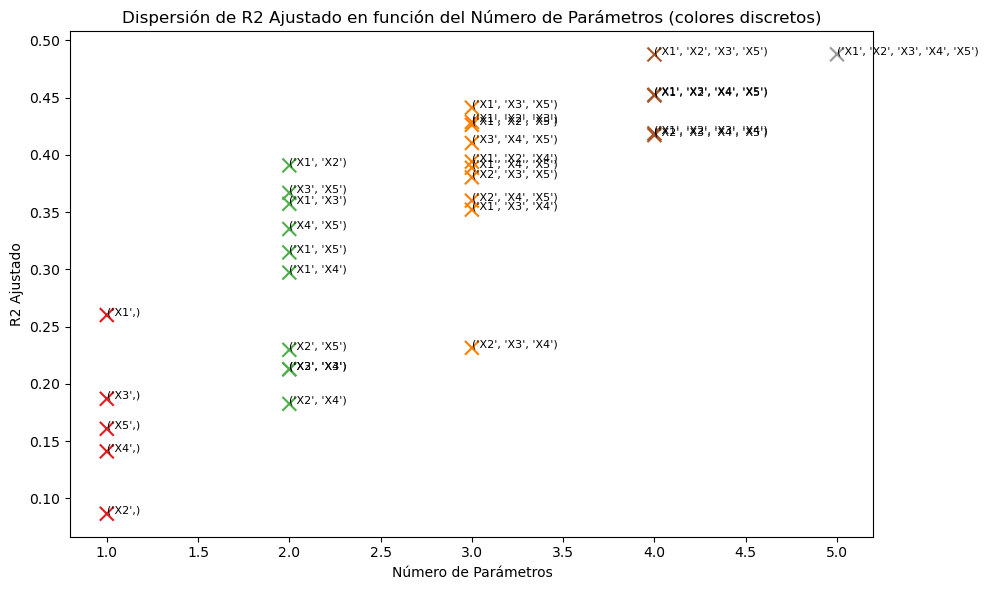

In [68]:
# Creamos el gráfico de dispersión sin la barra de colores a la derecha
plt.figure(figsize=(10, 6))

df_plot = pd.DataFrame()
df_plot['Num_parametros'] = resultados_posibles['Predictoras'].apply(lambda x: len(x))
df_plot['R2_adj'] = resultados_posibles['R2_adj']
df_plot['Predictoras'] = resultados_posibles['Predictoras']

plt.scatter(df_plot['Num_parametros'], df_plot['R2_adj'], c=df_plot['Num_parametros'], cmap='Set1', s=100, marker='x')

# Añadimos etiquetas para cada punto (los modelos)
for i in range(df_plot.shape[0]):
    plt.text(df_plot['Num_parametros'][i], df_plot['R2_adj'][i], df_plot['Predictoras'][i], fontsize=8)

# Añadimos etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('R2 Ajustado')
plt.title('Dispersión de R2 Ajustado en función del Número de Parámetros (colores discretos)')

# Mostramos el gráfico sin la barra de colores
plt.tight_layout()
plt.show()

### Posible modelo

In [69]:
# Definir las variables predictoras (X1) y la variable dependiente
X_final = X_non_influential_data[['X1', 'X2', 'X3', 'X5']]  # Usamos solo la variable X1
X_final = sm.add_constant(X_final)  # Agregar el intercepto
Y_final = non_influential_data[['Y']]

# Ajustar el modelo de regresión
model_final = sm.OLS(Y_final, X_final).fit()

# Mostrar el resumen del modelo
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     13.61
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           1.56e-07
Time:                        21:51:37   Log-Likelihood:                -64.130
No. Observations:                  54   AIC:                             138.3
Df Residuals:                      49   BIC:                             148.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4038      1.871      2.354      0.0

## 7. Prediccion

In [76]:
# Datos de entrada del modelo (los originales)
X_original = pd.DataFrame({
    'X1': df['X1'],     
    'X2': df['X2'],     
    'X3': df['X3'],     
    'X5': df['X5']     
})

# Agregar la constante
X_original = sm.add_constant(X_original)

# Realizar la predicción
predictions_final_model = model_final.predict(X_original)

# Mostrar las predicciones
comp = pd.DataFrame() 
comp['Y'] = df['Y']
comp['Y_pred'] = predictions_final_model
# Se muestran los 10 primeros elementos de la tabla
comp.head(10)

,Y,Y_pred
0,4.8,4.151870
1,5.0,5.333661
2,4.4,5.004486
3,3.7,3.859206
4,5.5,5.397823
5,1.7,2.968544
6,4.5,5.331876
7,5.7,5.245321
8,4.0,4.448194
9,4.2,3.640535


Este modelo tiene un ajuste moderado, con todas las variables predictoras significativas. Podría ser útil mejorarlo explorando otros predictores o combinaciones de variables, y sería recomendable realizar pruebas adicionales, como validación cruzada, para garantizar la robustez del modelo.


Las predicciones generadas por el modelo están relativamente cercanas a los valores reales. Sin embargo, hay algunas discrepancias, lo que podría indicar que hay cierta variabilidad en los datos que el modelo no está capturando completamente.
Algunas de las predicciones parecen bastante cercanas a los valores reales.

> **Importante**: Este notebook se apoyo en la IA para la generación de varios fragmentos de codigo python.

